In [ ]:
from keras.layers import Conv2D, Input
from keras.models import Model
from keras.losses import BinaryCrossentropy, MeanSquaredError
import keras
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from urllib import request
from keras import initializers

# **Test Image and CNN backbone**

In [ ]:
# Download test image
request.urlretrieve("https://i.imgur.com/XjeiRMV.jpg", "test.JPG")

('test.JPG', <http.client.HTTPMessage at 0x7fe814956520>)

333 500


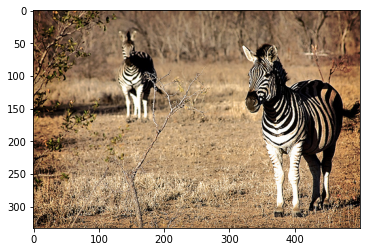

In [ ]:
image = cv.imread('/content/test.JPG')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_h, image_w, image_d = image.shape
print(image_h, image_w)
plt.imshow(image)

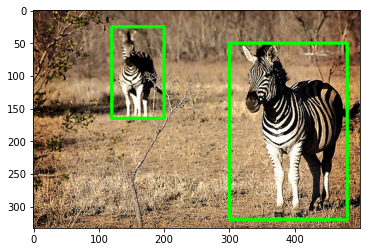

In [ ]:
bbox_list = np.array([[120, 25, 200, 165], [300, 50, 480, 320]])
n_object = len(bbox_list)
labels = np.array([1, 1])
image_copy = image.copy()

for i, bbox in enumerate(bbox_list):
  cv.rectangle(image_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
plt.imshow(image_copy)

[[192  60 320 396]
 [480 120 768 768]]


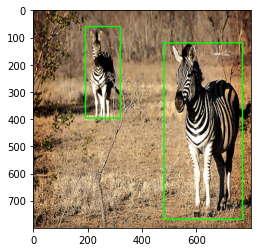

In [ ]:
h = w = 800
img = cv.resize(image, dsize=(h, w), interpolation=cv.INTER_CUBIC)
img_copy = img.copy()

x_alter = w/image_w
y_alter = h/image_h

bbox_list[:, 0] = bbox_list[:, 0] * x_alter
bbox_list[:, 1] = bbox_list[:, 1] * y_alter
bbox_list[:, 2] = bbox_list[:, 2] * x_alter
bbox_list[:, 3] = bbox_list[:, 3] * y_alter

for i, bbox in enumerate(bbox_list):
  cv.rectangle(img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
print(bbox_list)
plt.imshow(img_copy)

In [ ]:
img_  = np.expand_dims(img, axis=0)
print(img_.shape)
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

backbone = Model(inputs= [vgg.layers[0].input], outputs= [vgg.layers[17].output])
backbone.predict(img_).shape

(1, 800, 800, 3)
1/1 [==============================] - 13s 13s/step


(1, 50, 50, 512)

In [ ]:
feature_maps = backbone.predict(np.expand_dims(img, 0))
_, w_feature_map, h_feature_map, _ = feature_maps.shape

n_anchor_pos = w_feature_map * h_feature_map
feature_maps.shape

1/1 [==============================] - 7s 7s/step


(1, 50, 50, 512)

# **Get anchor center and anchor box**
**Total 2500 anchor center**

(2500, 2)


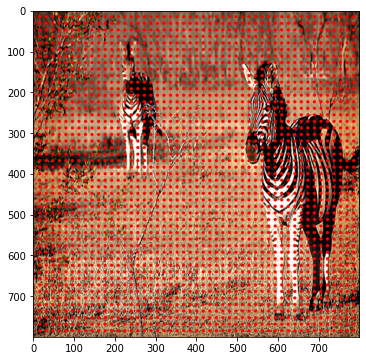

In [ ]:
x_stride = int(w / w_feature_map)
y_stride = int(h / h_feature_map)

x_center = np.arange(0, w, x_stride)
y_center = np.arange(0, h, y_stride)

center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1, 2)
print(center_list.shape)

img_ = img.copy()

for i, center in enumerate(center_list):
  cv.circle(img_, (center[0], center[1]), 1, (255, 0, 0), 5)
plt.figure(figsize=(9, 6))
plt.imshow(img_)

h*w=s, w/h=r => h*r*h=s => h = sqrt(s/r) => w = r*h

In [ ]:
anchor_list = []
anchor_ratio_list = [0.5, 1, 2]
anchor_scale_list = [8, 16, 32]
number_anchor = n_anchor_pos * len(anchor_ratio_list) * len(anchor_scale_list)

anchor_box = np.zeros(shape=(number_anchor, 4))
count = 0

for center in center_list:
  for r in anchor_ratio_list:
    for s in anchor_scale_list:
      h = np.sqrt(s/r)
      w = h*r

      h *= 80
      w *= 80

      x_min = center[0] - 0.5 * w
      y_min = center[1] - 0.5 * h
      x_max = center[0] + 0.5 * w
      y_max = center[1] + 0.5 * h

      anchor_list.append([center[0], center[1], w, h])
      anchor_box[count] = [x_min, y_min, x_max, y_max]
      count += 1

print(anchor_list)

[[0, 0, 160.0, 320.0], [0, 0, 226.27416997969522, 452.54833995939043], [0, 0, 320.0, 640.0], [0, 0, 226.27416997969522, 226.27416997969522], [0, 0, 320.0, 320.0], [0, 0, 452.54833995939043, 452.54833995939043], [0, 0, 320.0, 160.0], [0, 0, 452.54833995939043, 226.27416997969522], [0, 0, 640.0, 320.0], [0, 16, 160.0, 320.0], [0, 16, 226.27416997969522, 452.54833995939043], [0, 16, 320.0, 640.0], [0, 16, 226.27416997969522, 226.27416997969522], [0, 16, 320.0, 320.0], [0, 16, 452.54833995939043, 452.54833995939043], [0, 16, 320.0, 160.0], [0, 16, 452.54833995939043, 226.27416997969522], [0, 16, 640.0, 320.0], [0, 32, 160.0, 320.0], [0, 32, 226.27416997969522, 452.54833995939043], [0, 32, 320.0, 640.0], [0, 32, 226.27416997969522, 226.27416997969522], [0, 32, 320.0, 320.0], [0, 32, 452.54833995939043, 452.54833995939043], [0, 32, 320.0, 160.0], [0, 32, 452.54833995939043, 226.27416997969522], [0, 32, 640.0, 320.0], [0, 48, 160.0, 320.0], [0, 48, 226.27416997969522, 452.54833995939043], [0,

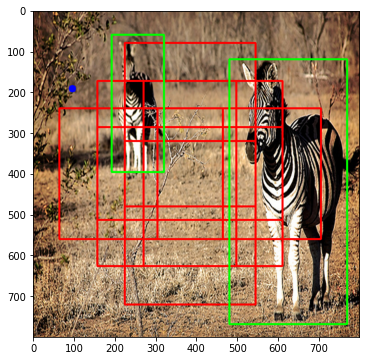

In [ ]:
# visualize anchor boxs at center anchor location
img_ = np.copy(img)
# mid anchor center = 2500/2 = 1250
for i in range(11025, 11034):  # 1250 * 9 = 11025 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_box[i][0])
    y_min = int(anchor_box[i][1])
    x_max = int(anchor_box[i][2])
    y_max = int(anchor_box[i][3])
    cv.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)
    
cv.circle(img_, (int(center_list[312][0]), int(center_list[312][1])), radius=1, color=(0, 0, 255), thickness=15) 

plt.figure(figsize=(9, 6))
plt.imshow(img_)
plt.show()

# **Filter anchor box**

*   Only chose anchor box inside image
*   IOU >= 0.7 => Class 1
*   IOU <= 0.3 => Class 0
*   Discard the others
*   Assign each anchor box to ground truth with max IOU




In [ ]:
inside_anchor_box_index = np.where(
    (anchor_box[:, 0] > 0) &
    (anchor_box[:, 1] > 0) &
    (anchor_box[:, 2] < 800) &
    (anchor_box[:, 3] < 800) 
)[0]

inside_anchor_box = anchor_box[inside_anchor_box_index]
n_inside_anchor_box = len(inside_anchor_box)
print(inside_anchor_box)

[[ 16.  16. 176. 336.]
 [ 16.  32. 176. 352.]
 [ 16.  48. 176. 368.]
 ...
 [624. 432. 784. 752.]
 [624. 448. 784. 768.]
 [624. 464. 784. 784.]]


In [ ]:
def IOU(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  if x2 > x1 and y2 > y1:
    area_overlap = (x2-x1)*(y2-y1)
  else:
    return 0
  
  area1 = (box1[2]-box1[0])*(box1[3]-box1[1])
  area2 = (box2[2]-box2[0])*(box2[3]-box2[1])

  area_union = area1 + area2 - area_overlap

  iou = area_overlap / area_union

  return iou

In [ ]:
iou_list = np.zeros((n_inside_anchor_box, n_object))

for i, g in enumerate(bbox_list):
  for j, a in enumerate(inside_anchor_box):
    iou_list[j][i] = IOU(g, a)

data = {"anchor_id": inside_anchor_box_index}
data.update({f"object_{i}_iou":iou_list[:, i] for i in range(n_object)})
data["max_iou"] = iou_list.max(axis=1)
data["best_gt"] = iou_list.argmax(axis=1)

df_iou = pd.DataFrame(data)

In [ ]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt
0,2799,0.0,0.000000,0.000000,0
1,2808,0.0,0.000000,0.000000,0
2,2817,0.0,0.000000,0.000000,0
3,2826,0.0,0.000000,0.000000,0
4,2835,0.0,0.000000,0.000000,0
...,...,...,...,...,...
6756,20115,0.0,0.240320,0.240320,1
6757,20124,0.0,0.240320,0.240320,1
6758,20133,0.0,0.240320,0.240320,1
6759,20142,0.0,0.240320,0.240320,1


In [ ]:
# getting anchor boxes having maximum IOU for each ground truth boxes
best_ious = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).max().values
print(f"Top IOUs for each object in the image: {best_ious}")

# getting anchor box idx having maximum overlap with ground truth boxes * ignoring anchor id column
best_anchors = df_iou.drop(["anchor_id", "max_iou", "best_gt"],axis= 1).values.argmax(axis= 0)
print(f"Top anchor boxes index: {best_anchors}")

# get all the anchor boxes having same IOU score
top_anchors = np.where(iou_list == best_ious)[0]
print(f"Anchor boxes with same IOU score: {top_anchors}")

Top IOUs for each object in the image: [0.76923077 0.88998764]
Top anchor boxes index: [ 987 6222]
Anchor boxes with same IOU score: [ 987 1205 1423 6222 6384]


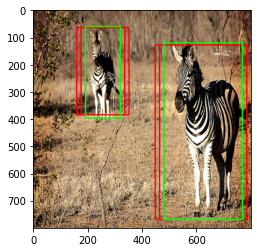

In [ ]:
img_ = np.copy(img)
for i in top_anchors:  
    x_min = int(inside_anchor_box[i][0])
    y_min = int(inside_anchor_box[i][1])
    x_max = int(inside_anchor_box[i][2])
    y_max = int(inside_anchor_box[i][3])
    cv.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

In [ ]:
labels = np.zeros(iou_list.shape[0], dtype=int)

labels.fill(-1)

labels[top_anchors] = 1
labels[np.where(df_iou.max_iou.values >= 0.7)] = 1
labels[np.where(df_iou.max_iou.values <= 0.3)] = 0

df_iou["label"] = labels

In [ ]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt,label
0,2799,0.0,0.000000,0.000000,0,0
1,2808,0.0,0.000000,0.000000,0,0
2,2817,0.0,0.000000,0.000000,0,0
3,2826,0.0,0.000000,0.000000,0,0
4,2835,0.0,0.000000,0.000000,0,0
...,...,...,...,...,...,...
6756,20115,0.0,0.240320,0.240320,1,0
6757,20124,0.0,0.240320,0.240320,1,0
6758,20133,0.0,0.240320,0.240320,1,0
6759,20142,0.0,0.240320,0.240320,1,0


# **Balancing anchor label**

In [ ]:
def sample_anchor_pre(df, n_samples=256, negative_ratio=0.5):
  foreground_index_list = df[df.label == 1].index.values
  background_index_list = df[df.label == 0].index.values
  n_background = int(n_samples * negative_ratio)
  n_foreground = int(n_samples * (1-n_samples))

  if len(foreground_index_list) > n_foreground:
    ignore_foreground = foreground_index_list[n_foreground:]
    df.loc[ignore_foreground, 'label'] = -1

  if len(foreground_index_list) < n_foreground:
    diff = n_foreground - foreground_index_list
    n_background += diff

  if len(background_index_list) > n_background:
    ignore_background = background_index_list[n_background:]
    df.loc[ignore_background, 'label'] = -1


In [ ]:
sample_anchor_pre(df_iou)

In [ ]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt,label
0,2799,0.0,0.000000,0.000000,0,0
1,2808,0.0,0.000000,0.000000,0,0
2,2817,0.0,0.000000,0.000000,0,0
3,2826,0.0,0.000000,0.000000,0,0
4,2835,0.0,0.000000,0.000000,0,0
...,...,...,...,...,...,...
6756,20115,0.0,0.240320,0.240320,1,-1
6757,20124,0.0,0.240320,0.240320,1,-1
6758,20133,0.0,0.240320,0.240320,1,-1
6759,20142,0.0,0.240320,0.240320,1,-1


# **Compute dx, dy, dw, dh**
**văn bản in đậm**

In [ ]:
def to_center_format(x1, y1, x2, y2):
  width = x2 - x1
  height = y2 - y1
  x = x1 + 0.5*width
  y = y1 + 0.5*width

  return x, y, width, height

In [ ]:
inside_anchor_x, inside_anchor_y, inside_anchor_w, inside_anchor_h = to_center_format(
    inside_anchor_box[:, 0],
    inside_anchor_box[:, 1],
    inside_anchor_box[:, 2],
    inside_anchor_box[:, 3])

gt_list = []
for i in df_iou.best_gt.values:
  gtruth = bbox_list[i]
  gt_list.append(gtruth)

gt_list = np.array(gt_list)

gt_x, gt_y, gt_w, gt_h = to_center_format(gt_list[:, 0], gt_list[:, 1], gt_list[:, 2], gt_list[:, 3])

In [ ]:
eps = np.finfo(inside_anchor_w.dtype).eps
inside_anchor_h = np.maximum(inside_anchor_h, eps)
inside_anchor_w = np.maximum(inside_anchor_w, eps)

dx = (gt_x - inside_anchor_x) / inside_anchor_w
dy = (gt_y - inside_anchor_y) / inside_anchor_h
dw = np.log(gt_w / inside_anchor_w)
dh = np.log(gt_h / inside_anchor_h)

In [ ]:
df_iou["dx"] = dx
df_iou["dy"] = dy
df_iou["dw"] = dw
df_iou["dh"] = dh

In [ ]:
df_iou

,anchor_id,object_0_iou,object_1_iou,max_iou,best_gt,label,dx,dy,dw,dh
0,2799,0.0,0.000000,0.000000,0,0,1.0,0.0875,-0.223144,0.04879
1,2808,0.0,0.000000,0.000000,0,0,1.0,0.0375,-0.223144,0.04879
2,2817,0.0,0.000000,0.000000,0,0,1.0,-0.0125,-0.223144,0.04879
3,2826,0.0,0.000000,0.000000,0,0,1.0,-0.0625,-0.223144,0.04879
4,2835,0.0,0.000000,0.000000,0,0,1.0,-0.1125,-0.223144,0.04879
...,...,...,...,...,...,...,...,...,...,...
6756,20115,0.0,0.240320,0.240320,1,-1,-0.5,-0.6750,0.587787,0.70557
6757,20124,0.0,0.240320,0.240320,1,-1,-0.5,-0.7250,0.587787,0.70557
6758,20133,0.0,0.240320,0.240320,1,-1,-0.5,-0.7750,0.587787,0.70557
6759,20142,0.0,0.240320,0.240320,1,-1,-0.5,-0.8250,0.587787,0.70557


# **Build first Train Model**


In [ ]:
labels_list = np.empty(number_anchor, dtype=np.float32)
labels_list.fill(-1)
labels_list[df_iou.anchor_id.values] = df_iou.label.values
labels_list= np.expand_dims(labels_list, 0)
labels_list= np.expand_dims(labels_list, -1)
print(labels_list.shape)

(1, 22500, 1)


In [ ]:
offset_list = np.empty(anchor_box.shape, dtype=np.float32)
offset_list.fill(0)
offset_list[df_iou.anchor_id.values] = df_iou[["dx", "dy", "dw", "dh"]].values
offset_list = np.expand_dims(offset_list, 0)
print(offset_list.shape)

(1, 22500, 4)


In [ ]:
offset_list_labels_list = np.column_stack((offset_list[0], labels_list[0]))[np.newaxis,:]
offset_list_labels_list.shape

(1, 22500, 5)

In [ ]:
input_shape = (w_feature_map, h_feature_map, 512) # 50x50X512
k = 9
input_ = Input(shape= input_shape)
conv1 = Conv2D(512,kernel_size= 3, padding= "same",)(input_) # (kw * iw + 2*padding_w / s_w) + 1

# delta regression
regressor = Conv2D(4*k, kernel_size= 1, activation= "linear", name= "delta_regression")(conv1) # (-1, 36)

# objectiveness score
classifier = Conv2D(k*1, kernel_size= 1, activation= "sigmoid", name="objectivess_score")(conv1)

RPN = Model(inputs= [input_], outputs= [regressor, classifier])

In [ ]:
RPN.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 512  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 512)  2359808     ['input_2[0][0]']                
                                                                                                  
 delta_regression (Conv2D)      (None, 50, 50, 36)   18468       ['conv2d[0][0]']                 
                                                                                                  
 objectivess_score (Conv2D)     (None, 50, 50, 9)    4617        ['conv2d[0][0]']           

In [ ]:
a = [[-1.0, 2.0], [3.0, 4.0]]
a = np.array(a)
b = [[5,6], [7, 8]]
b = np.array(b)
x = K.cast(K.less(a, 1.0), "float32")
print(x)

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


# **Train Model**

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    """
    Calculates Smooth L1 loss
    """

    # Take absolute difference
    x = K.abs(y_true - y_pred)

    # Find indices of values less than 1
    mask = K.cast(K.less(x, 1.0), "float32")
    # Loss calculation for smooth l1
    loss = (mask * (0.5 * x ** 2)) + (1 - mask) * (x - 0.5)
    return loss


def custom_l1_loss(y_true, y_pred):
    """
    Regress anchor offsets(deltas) * only consider foreground boxes
    """
    offset_list= y_true[:,:,:-1]
    label_list = y_true[:,:,-1]
    
    # reshape output by the model
    y_pred = tf.reshape(y_pred, shape= (-1, number_anchor, 4))
    
    positive_idxs = tf.where(K.equal(label_list, 1)) # select only foreground boxes
    
    # Select positive predicted bbox shifts
    bbox = tf.gather_nd(y_pred, positive_idxs)
    
    target_bbox = tf.gather_nd(offset_list, positive_idxs)
    loss = smooth_l1_loss(target_bbox, bbox)

    return K.mean(loss)

def custom_binary_loss(y_true, y_pred_objectiveness):
    '''
    Select both foreground and background class and compute cross entropy
    '''
    
    y_pred = tf.reshape(y_pred_objectiveness, shape= (-1, number_anchor))
    y_true = tf.squeeze(y_true, -1)
    
    # Find indices of positive and negative anchors, not neutral
    indices = tf.where(K.not_equal(y_true, -1)) # ignore -1 labels

    # Pick rows that contribute to the loss and filter out the rest.
    rpn_match_logits = tf.gather_nd(y_pred, indices)
    anchor_class = tf.gather_nd(y_true, indices)
    
    
    # Cross entropy loss
    loss = K.binary_crossentropy(target=anchor_class,
                                output=rpn_match_logits
                                )
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    
    return loss

RPN.compile(loss = [custom_l1_loss, custom_binary_loss], optimizer= "adam")

In [ ]:
RPN.fit(feature_maps,[offset_list_labels_list, labels_list], epochs= 100)

In [ ]:
# get the offset and objectiveness score
anchor_deltas, objectiveness_score = RPN.predict(feature_maps)


# shape both predictions
anchor_deltas = anchor_deltas.reshape(-1, number_anchor, 4) # 50*50*9, 4
objectiveness_score = objectiveness_score.reshape(-1, number_anchor) # 50*50*9, 1

# parse anchor deltas
dx = anchor_deltas[:, :, 0]
dy = anchor_deltas[:, :, 1]
dw = anchor_deltas[:, :, 2]
dh = anchor_deltas[:, :, 3]

print(anchor_deltas.shape, objectiveness_score.shape)

1/1 [==============================] - 0s 242ms/step
(1, 22500, 4) (1, 22500)


# **Clipping, Filtering And Non-max Suppression**

In [ ]:
anchor_box = anchor_box.squeeze()
anchor_box = np.expand_dims(anchor_box, 0)
anchor_box.shape

(1, 22500, 4)

In [ ]:
def adjust_deltas(anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh):

    center_x = dx * anchor_width + anchor_center_x 
    center_y = dy *  anchor_height + anchor_center_y
    width = np.exp(dw) * anchor_width
    height = np.exp(dh) * anchor_height
    
    return width, height, center_x, center_y

In [ ]:
anchor_width, anchor_height, anchor_center_x, anchor_center_y =  to_center_format(
    anchor_box[0][:, 0], 
    anchor_box[0][:, 1],
    anchor_box[0][:, 2],
    anchor_box[0][:, 3])

roi_width, roi_height, roi_center_x, roi_center_y = adjust_deltas(anchor_width,
                                                      anchor_height,
                                                      anchor_center_x,
                                                      anchor_center_y,
                                                      dx,
                                                      dy,
                                                      dw,
                                                      dh)

<ipython-input-178-6077f596fea7>:5: RuntimeWarning: overflow encountered in exp
  width = np.exp(dw) * anchor_width
<ipython-input-178-6077f596fea7>:6: RuntimeWarning: overflow encountered in exp
  height = np.exp(dh) * anchor_height


In [ ]:
def to_VOC_format(width, height, center_x, center_y):
  
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

In [ ]:
roi_min_x, roi_min_y, roi_max_x, roi_max_y = to_VOC_format(roi_width, roi_height, roi_center_x, roi_center_y)
roi = np.vstack((roi_min_x, roi_min_y, roi_max_x, roi_max_y)).T

In [ ]:
roi = np.clip(roi, 0, 800)

In [ ]:
min_size = 16
width = roi[:, 2] - roi[:, 0] # xmax - xmin
height = roi[:, 3] - roi[:, 1] # ymin - ymax
keep = np.where((width > min_size) & (height> min_size))[0]
roi = roi[keep]
score = objectiveness_score[:,keep]

In [ ]:
# Sort all (proposal, score) pairs by score from highest to lowest.
sorted_idx = score.flatten().argsort()[::-1]
score_sorted = score[:, sorted_idx]
roi_sorted = roi[sorted_idx]

In [ ]:
sorted_idx.shape, score_sorted.shape, roi_sorted.shape

((6675,), (1, 6675), (6675, 4))

In [ ]:
# select top N proposals (top 12000)
pre_NMS_topN = 6000
score_sorted = score_sorted[:, :pre_NMS_topN]
roi_sorted = roi_sorted[:pre_NMS_topN]

In [ ]:
# apply non-max supression on 12000 roi
roi_idx = np.array(range(pre_NMS_topN))

# total number of ROIs to select after NMS
n_train_post_nms = 2000


x1 = roi_sorted[:, 0]
y1 = roi_sorted[:, 1]
x2 = roi_sorted[:, 2]
y2 = roi_sorted[:, 3]

# area of all roi
# + 1 to prevent division by zero
width_list = (x2 - x1) + 1 
height_list = (y2 - y1) + 1
area_list =  width_list * height_list

# rois to keep as region proposals
keep = []

while roi_idx.size > 0:
    # take the first roi index
    current_id = roi_idx[0]
    
    # add the current rio to keep list
    keep.append(current_id)
    
    # maximum of x1 of current and all other x1 roi
    xx1 = np.maximum(x1[current_id], x1[roi_idx[1:]])
    
    # maximum of y1 of current and all other y1 roi
    yy1 = np.maximum(y1[current_id], y1[roi_idx[1:]])
    
    # maximum of x2 of current and all other x2 roi
    xx2 = np.minimum(x2[current_id], x2[roi_idx[1:]])
    
    # maximum of y2 of current and all other y2 roi
    yy2 = np.minimum(y2[current_id], y2[roi_idx[1:]])
    
    # width of all the intersection area
    w = np.maximum(0. ,xx2 - xx1 +1)
    
    # height of all the intersection boxes
    h = np.maximum(0., yy2 - yy1 +1)
    
    # area of all the intersection boxes
    inter = w * h
    
    # IOU current ROI and rest of the ROIs
    iou = inter/ (area_list[current_id] + area_list[roi_idx[1:]] - inter)
    # select boxes whose overlap is less than the threshold
    keep_idx = np.where(iou <= 0.7)[0]
    
    # update the ROI index list(* note +1 to the indices list)
    roi_idx = roi_idx[keep_idx + 1]

In [ ]:
keep = keep[: n_train_post_nms]
roi_sorted = roi_sorted[keep]
score_sorted = score_sorted[:, keep]

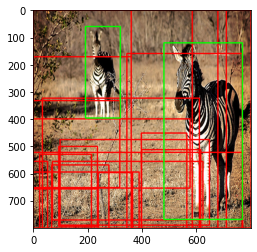

In [ ]:
# visualizing top 20 anchor boxes
img_ = np.copy(img)
for i in range(0, 20):  # 5625// 2
    x_min = int(roi_sorted[i][0])
    y_min = int(roi_sorted[i][1])
    x_max = int(roi_sorted[i][2])
    y_max = int(roi_sorted[i][3])
    cv.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()

# Final Post Processing ( assigning ground truth boxes and lables to the top 2000 region proposals (adjusted anchor boxes)
After getting top 2000 anchor boxes, we will assign each of the anchor box to the ground truth box based on the IOU ( exactly same process as we have performed earlier).

After assignment of ground truth boxes to the region proposals, we will further eliminate the anchor boxes based on the following rule.
* Assign label "1" (as foreground) to the bounding boxes whose overlap with any ground truth box is greater than 50%
* Assign label "0" (as background) to the bounding boxes whose overlap with any ground truth box is smaller than 50% but greater than equal to 10%.

In [ ]:
# find IOU of all region proposals with all ground truth boxes
iou_sorted = np.zeros((n_train_post_nms, len(labels)))

# for each proposal
for i, bbox in enumerate(roi_sorted):
    
    # for each ground truth box
    for j, gt_box in enumerate(bbox_list):
        iou_sorted[i][j] = IOU(bbox, gt_box)

# get the max iou for each proposal
max_iou_sorted = np.max(iou_sorted, axis= 1)

# assign the ground truth box to each proposal
gt_assign = np.argmax(iou_sorted, axis= 1)

# assign class labels to each proposal
gt_roi_label = labels[gt_assign] # {"dog":1, "cat":2, and so on}, this will be used by RPN classification head

In [ ]:
# threshold for foreground and background labels
pos_threshold = 0.5
neg_threshold_hi = 0.5
neg_threshold_lo = 0.1

# select proposals whose IOU is atleast 50%
keep_pos_idx_list = np.where(max_iou_sorted >= pos_threshold)[0]

# select proposals whose IOU is less than 50% but greater than or equal to lower limit 10%
keep_neg_idx_list = np.where((max_iou_sorted < neg_threshold_hi) & (max_iou_sorted >=neg_threshold_lo))[0]

In [ ]:
# select 128 proposals of both classes (foreground and background)
n_samples = 128
neg_ratio = 0.75
# number of foreground and background class
n_foreground = int((1-neg_ratio) * n_samples)
n_backgroud = int(neg_ratio * n_samples)

# index of foreground and background ROIs
foreground_index_list = keep_pos_idx_list
background_index_list = keep_neg_idx_list

# check if we have excessive foreground samples
if len(foreground_index_list) > n_foreground:
    # randomly sample 32 foreground proposals
    select_pos_index_list = np.random.choice(foreground_index_list, n_foreground)
else:
    select_pos_index_list = foreground_index_list

# sample background examples if we don't have enough positive examples to match the anchor batch size
if len(foreground_index_list) < n_foreground:
    diff = n_foreground - len(foreground_index_list)
    # add remaining value to background examples
    n_backgroud += diff

# check if we have excessive background samples
if len(background_index_list) > n_backgroud:
    # randomly sample remaining proposals as negative
    select_neg_index_list = np.random.choice(background_index_list, n_backgroud)
else:
    select_neg_index_list = background_index_list

# combine both the index list, foreground and background
keep = np.hstack([select_pos_index_list, select_neg_index_list])

In [ ]:
# select corresponding proposals and labels
sample_roi = roi_sorted[keep]
gt_roi_labels = gt_roi_label[keep]
# mark the background classes
gt_roi_labels[select_pos_index_list.shape[0]:] = 0

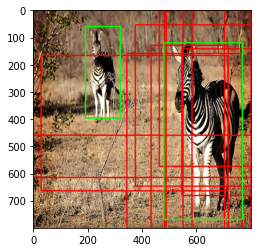

In [ ]:
# visualizing foreground proposals
img_ = np.copy(img)

for i in range(10):  # 5625// 2
    # visualizing foreground proposals
    x_min = int(sample_roi[i][0])
    y_min = int(sample_roi[i][1])
    x_max = int(sample_roi[i][2])
    y_max = int(sample_roi[i][3])
    cv.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

for i, bbox in enumerate(bbox_list):
    cv.rectangle(img_, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=3)

plt.imshow(img_)
plt.show()